<a href="https://colab.research.google.com/github/sigmunjr/TEK5030_deep_learning/blob/master/TEK5030_deep_learning_EX3_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 3: Segmentation

We use the same dataset as in *Exercise 1*, but now instead of classifying dogs vs. cats, we try to output a segmentation mask. In other words simply classify each pixel, for this dataset simply into *animal* and not *animal*.

First we load the dataset, just as last time.

In [8]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

tfds.disable_progress_bar()

def load_image(datapoint):
  input_image = tf.cast(tf.image.resize(datapoint['image'], (128, 128)), tf.float32) / 255.
  print(datapoint['segmentation_mask'].dtype)
  input_mask = tf.math.abs(tf.image.resize(
    tf.cast(datapoint['segmentation_mask'], tf.int64), (128, 128), 'nearest'
    ) - 2)
  print('Data in datapoint:', list(datapoint.keys()))

  return input_image, input_mask, datapoint['species']

dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True, download_and_prepare_kwargs={'download_config': tfds.download.DownloadConfig(register_checksums=True)})
train_data = dataset['train'].map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_data = dataset['test'].map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

<dtype: 'uint8'>
Data in datapoint: ['file_name', 'image', 'label', 'segmentation_mask', 'species']
<dtype: 'uint8'>
Data in datapoint: ['file_name', 'image', 'label', 'segmentation_mask', 'species']


## Creating a segmentation network

A segmentation network is very similar to a classification network, except that your output need to be in the same spatial dimentions as your input.

### Simple segmentation network
The simplest way of doing this is to run a fully-convolutional network (only convolutionas and per-pixel operations). This approach was first proposed by the paper [Fully Convolutional Networks for Semantic Segmentation](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Long_Fully_Convolutional_Networks_2015_CVPR_paper.pdf).

You need to make sure you have some spatiel information left (If the shape of your output is Batch-size*N*M*C, then N and M should be larger than 1 (probably N, M > 5).

I use [tf.image.resize](https://www.tensorflow.org/api_docs/python/tf/image/resize) to resize the output of the network. This implements gradients, so we can run backpropagation through the function.

In [0]:
import cv2
import numpy as np
import tensorflow as tf

from tensorflow.keras import Model
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Dense, Dropout

class SmallSegmentationNet(Model):
    def __init__(self):
        super(SmallSegmentationNet, self).__init__()
        # TODO: Intialize the components of the network
        self.conv1 = Conv2D(32, 5, strides=3, activation=tf.nn.relu, padding='same')
        self.conv2 = Conv2D(32, 5, strides=2, activation=tf.nn.relu, padding='same')
        self.conv3 = Conv2D(2, 5, activation=None, padding='same')

    def call(self, x, **kwargs):
        in_size = x.shape
        # Run your network
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = tf.image.resize(x, in_size[1:3])
        return x

    @staticmethod
    def loss(pred, label):
      #TODO: Write your own loss function.
      return tf.reduce_mean((pred - tf.cast(label, tf.float32)) ** 2)


## Train your network

Luckily enough Keras have at this point support for using [tf.keras.losses.SparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy), for segmentation. So you can use this out of the box as long as your outputs final dimenstion size is equal to the number of classes.

**TODO:**
- Train your network with SparseCategoricalCrossentropy
- Try to make your own loss function.

Creating your own loss function with tf.GradientTape just mean that you have to output some value, that you want to optimize. Then calculate your gradients to that value, with tape.gradient(*YOUR_VALUE*, model.trainable_variables).

If your are using the *model.fit* method, you need to provide a function that takes the network output and target values. Example:

    def my_loss_function(network_output, target_values):
      return tf.math.reduce_sum(network_output * target_values)
    
    model.compile(
      ...,
      loss=my_loss_function,
      ...
      )

The function should simpliy return the value you want to minimize.

In [14]:
model = UNet() # SmallSegmentationNet()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
    run_eagerly=False,
    )
train_ds = train_data.map(lambda img, mask, label: (img, mask)).shuffle(256, reshuffle_each_iteration=True)
test_ds = test_data.map(lambda img, mask, label: (img, mask))

print('EVALUATE', model.evaluate(train_ds.take(32).batch(32)))
model.fit(train_ds.batch(64), epochs=13, validation_data=test_ds.take(128).batch(64))
model.evaluate(test_ds.batch(64))

1/1 [==============================] - 0s 1ms/step - loss: 0.7368 - accuracy: 0.4402
EVALUATE [0.7368004322052002, 0.4402046203613281]
Epoch 1/13
58/58 [==============================] - 55s 953ms/step - loss: 0.6377 - accuracy: 0.5004 - val_loss: 0.5239 - val_accuracy: 0.6732
Epoch 2/13
58/58 [==============================] - 55s 949ms/step - loss: 0.4647 - accuracy: 0.8081 - val_loss: 0.2398 - val_accuracy: 0.9024
Epoch 3/13
58/58 [==============================] - 55s 954ms/step - loss: 0.2284 - accuracy: 0.9064 - val_loss: 0.1880 - val_accuracy: 0.9277
Epoch 4/13
58/58 [==============================] - 55s 948ms/step - loss: 0.1849 - accuracy: 0.9258 - val_loss: 0.1685 - val_accuracy: 0.9324
Epoch 5/13
 1/58 [..............................] - ETA: 0s - loss: 0.1860 - accuracy: 0.9267

KeyboardInterrupt: ignored

## Visualizing your result

**TODO**: Inside the loop iterating through the test data, run your model and plot the result.

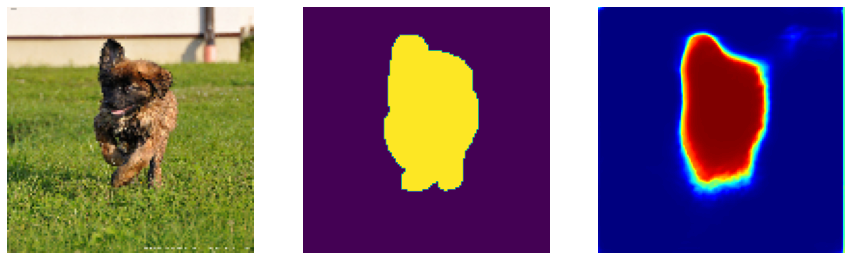

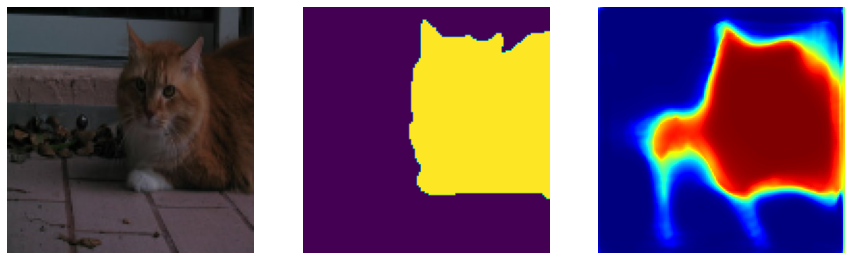

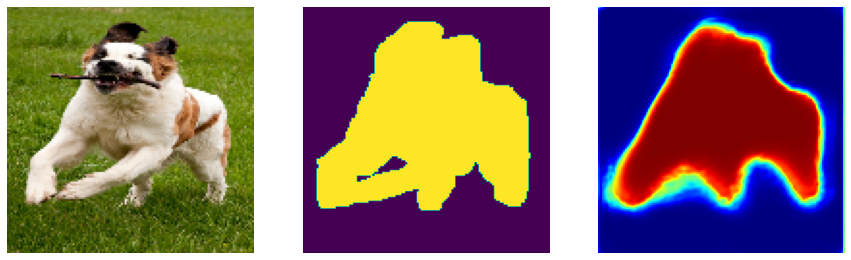

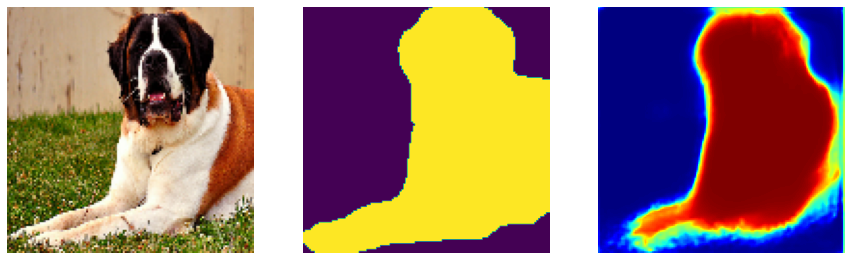

In [18]:
def display(display_list, titles=None, cmaps={}):
  """ Plotting images in list """
  from matplotlib import cm
  plt.figure(figsize=(15, 15))

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    if titles != None:
      plt.title(titles[i])
    plt.imshow(
        display_list[i],
        vmin=0,
        vmax=1,
        cmap=cmaps[i] if i in cmaps else None
        )
    plt.axis('off')
  plt.show()

for image, mask, label in test_data.take(4):
  # TODO: Get the output from your network
  out = tf.nn.softmax(model(image[np.newaxis])).numpy()[0, :, :, 1]

  #TODO: plot the output
  display([image.numpy(), mask.numpy().squeeze(), out.squeeze()], cmaps={2: 'jet'})

## Extra challenge

Using the streigh forward fully-convolutional approach is simple, but you do lose much of the spatial information, makeing the network less precise. A better approach is to us a [U-Net](https://arxiv.org/pdf/1505.04597.pdf) type architecture. Here you make skip-connection, either by simple addition or by concatinating the outputs. This can be done by only changing the *call* method in the network. Then the output can be resized multiple times with tf.image.resize and the skip-connection can be done with [tf.concat](https://www.tensorflow.org/api_docs/python/tf/concat) or simply +. It is not necessary to use max-pooling or up-convolution/Conv2DTransposed.

![u-net](https://media.springernature.com/m685/springer-static/image/art%3A10.1038%2Fs41598-019-53797-9/MediaObjects/41598_2019_53797_Fig1_HTML.png)

In [16]:
import tensorflow as tf
import numpy as np

from tensorflow.keras import Model
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Input, Layer
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2


class UNet(Model):
    def __init__(self):
        super(UNet, self).__init__()
        
        # TODO: Intialize the components of the network
        self.base_net = MobileNetV2(weights='imagenet', include_top=False)
        input = Input([None, None, 3])
        new_model_output = [l.output for l in self.base_net.layers[::8]]
        self.up_conv_layers = []
        
        for o in new_model_output[:-1]:
          self.up_conv_layers.append([
            Conv2D(o.shape[-1], 3, activation=tf.nn.relu, padding='same'),
            Conv2D(o.shape[-1], 3, activation=tf.nn.relu, padding='same')
          ])

        self.base_net = tf.keras.Model(self.base_net.layers[0].input, new_model_output)
        for l in self.base_net.layers:
          l.trainable = False

        self.last_layer1 = Conv2D(64, 1, activation=tf.nn.relu, padding='same')
        self.last_layer2 = Conv2D(2, 1, activation=None, padding='same')

    def call(self, x, **kwargs):
        in_size = x.shape
        base_out = self.base_net(x)

        prev_out = base_out[-1]
        for i, (out, up_conv) in enumerate(zip(base_out[::-1][1:], self.up_conv_layers[::-1])):
          up_out = tf.image.resize(prev_out, out.shape[1:3])
          for c in up_conv:
            up_out = c(up_out)
          prev_out = up_out + out
        x = prev_out
        x = self.last_layer1(x)
        x = self.last_layer2(x)

        return tf.image.resize(x, in_size[1:3])

    @staticmethod
    def loss(pred, label):
      #TODO: Write your own loss function. Use it with SmallSegmentationNet.loss
      return 0.0

unet = UNet()
unet(np.random.random((1, 128, 128, 3))).shape



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([1, 128, 128, 2])